### COMP-546DL 
### Deep Learning and Reinforcement Learning
### Assignment 4 - Spam Filtering
### Ioannis Stathakis - December 2024

#

### Let's start by importing the necessary libraries and modules, and having a general look at the data.

In [1]:
# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.utils import resample

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import layers, models
from tensorflow.python.keras.layers import Dense, Activation, Input
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [2]:
# Importing the dataset
emails_data = pd.read_csv("emails.csv", header=0)

In [3]:
emails_data.head()

,Email No.,the,to,ect,and,for,of,a,you,hou,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,Email 1,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Email 2,8,13,24,6,6,2,102,1,27,...,0,0,0,0,0,0,0,1,0,0
2,Email 3,0,0,1,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Email 4,0,5,22,0,5,1,51,2,10,...,0,0,0,0,0,0,0,0,0,0
4,Email 5,7,6,17,1,5,2,57,0,9,...,0,0,0,0,0,0,0,1,0,0


In [4]:
# Checking out some general info
emails_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Columns: 3002 entries, Email No. to Prediction
dtypes: int64(3001), object(1)
memory usage: 118.5+ MB


In [5]:
# Checking for potential class balance issues
emails_data["Prediction"].value_counts()

Prediction
0    3672
1    1500
Name: count, dtype: int64

#

### **Part 1: Data Preprocessing**

#### There seems to be a potential issue with the balance of the binary class we are interested in (spam and no-spam mails are imbalaced).
#### We need to deal with this before the training phase, to avoid classifying bias of the model.
#### One way to go about this, is to oversample the spam data (minority class), to match the total of the non-spam data. After this oversampling, we combine the oversampled and majority classes into a single balanced dataset. We do all this before the final train/test/split of the dataset.

#### For the validation and train splits, I will split the dataset into 70% training, 15% validation, and 15% test sets, maintaining the balanced class distribution.

In [17]:
# Now I will prepare the dataset for training/validation
# As already described, the dataset will be balanced and split into separate sets for each respective utility
# I will also save the sets for later use and replication if needed

# Separate features and labels
# We need to do this in order to balance the dataset
spam_data = emails_data[emails_data['Prediction'] == 1] 
not_spam_data = emails_data[emails_data['Prediction'] == 0]

# Oversample the spam data to match the count of non-spam data
spam_oversampled = resample(spam_data,
                            replace=True,  # Allow resampling with replacement
                            n_samples=len(not_spam_data),  # Match the majority class count
                            random_state=20) # For replication purposes

# Combine the oversampled spam data with the non-spam data
balanced_data = pd.concat([not_spam_data, spam_oversampled]).sample(frac=1, random_state=42)

# Separate features and labels
X = balanced_data.drop(columns=['Email No.', 'Prediction'])
y = balanced_data['Prediction']

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Save the splits for later use
X_train.to_csv('X_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
X_val.to_csv('X_val.csv', index=False)
y_val.to_csv('y_val.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

# A little reassurance...!
print("Processing complete. Training, validation, and test sets have been saved.")

Processing complete. Training, validation, and test sets have been saved.


#

### **Part 2: Manual Feedforward Neural Network Experiments (Classifier #1 - Trial #1)**

#### For this approach I will manually compile a simple initial feedforward model to use as a performance baseline, and see what improvements and experimentations we can do afterwards.
#### The initial architecture is two Dense layers with Relu activation and static Dropout rate of 0.3, followed by the Dense output layer (sigmoid activation).

#### The optimizer used initial will be Adam, with a static learning rate of 0.001, and we will experiment with learning rate decay at a later step, if we need to.

#### Implementation of early stopping as an overfitting prevention measure is also considered, and the metrics followed will be mainly Accuracy and F1-Score.

In [18]:
# Define the first trials model architecture
model1 = Sequential()
model1.add(keras.layers.InputLayer(shape=(X_train.shape[1],))) # Input shape is defined here
model1.add(Dense(128, activation='relu'))  
model1.add(Dropout(0.3))
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# This function is to take into consideration the F1 Score
# Since this metric is the basic focus, it would be nice if we can keep track of it as well
# The function will compute the F1 score using ground truth labels (y_true) and predicted labels (y_pred)
def f1_score(y_true, y_pred):
    
    # Ensure y_true and y_pred are the same type
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.round(tf.cast(y_pred, tf.float32))  # Round predictions to 0 or 1
    
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float32'))
    precision = tp / (tf.reduce_sum(tf.cast(y_pred, 'float32')) + tf.keras.backend.epsilon())
    recall = tp / (tf.reduce_sum(tf.cast(y_true, 'float32')) + tf.keras.backend.epsilon())
    return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

# Compiling the model
model1.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', f1_score])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training the model
history1 = model1.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stopping],
                    verbose=1)

# Evaluating on the test set
y_pred = (model1.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

Epoch 1/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7236 - f1_score: 0.7323 - loss: 0.8101 - val_accuracy: 0.9610 - val_f1_score: 0.9599 - val_loss: 0.1696
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9213 - f1_score: 0.9172 - loss: 0.3651 - val_accuracy: 0.9846 - val_f1_score: 0.9857 - val_loss: 0.0813
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9686 - f1_score: 0.9682 - loss: 0.1280 - val_accuracy: 0.9646 - val_f1_score: 0.9661 - val_loss: 0.1627
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9810 - f1_score: 0.9801 - loss: 0.0726 - val_accuracy: 0.9782 - val_f1_score: 0.9801 - val_loss: 0.0976
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9840 - f1_score: 0.9845 - loss: 0.0611 - val_accuracy: 0.9855 - val_f1_score: 0.9867 - val_loss: 0.0563
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9748 - f1_score: 0.9752 - loss: 0.0919 - val_accuracy: 0.9900 - val_f1_score: 0.9903

#

### Defining some visualization functions to be used with each model

In [19]:
# This will be a function to visualize the results 
# This way we can use it on every trial and save coding time

# This function will consider Accuracy and Loss
def plot_training_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)
    
    plt.figure(figsize=(12, 8), facecolor="lightgrey")
    
    # Plot accuracy
    plt.subplot(2, 1, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy', size=15)
    plt.xlabel('Epochs', size=12)
    plt.ylabel('Accuracy', size=12)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(axis="y", linestyle="--", linewidth=0.5)
    
    # Plot loss
    plt.subplot(2, 1, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss', marker='o', color="royalblue")
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss', marker='o', color="lightcoral")
    plt.title('Training and Validation Loss', size=15)
    plt.xlabel('Epochs', size=12)
    plt.ylabel('Loss', size=12)
    plt.legend(loc='upper right', fontsize=12)
    plt.grid(axis="y", linestyle="--", linewidth=0.5)
    
    plt.tight_layout()
    plt.show()

# This visualization function will consider the F1-score
def plot_f1_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)
    
    plt.figure(figsize=(8, 6), facecolor="lightgrey")
    
    # Plot F1-score
    plt.plot(epochs, history.history['f1_score'], label='Training F1-Score', marker='o', color="steelblue")
    plt.plot(epochs, history.history['val_f1_score'], label='Validation F1-Score', marker='o', color="yellowgreen")
    plt.title('Training and Validation F1-Score', size=15)
    plt.xlabel('Epochs', size=12)
    plt.ylabel('F1-Score', size=12)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(axis="y", linestyle="--", linewidth=0.5)
    plt.show()


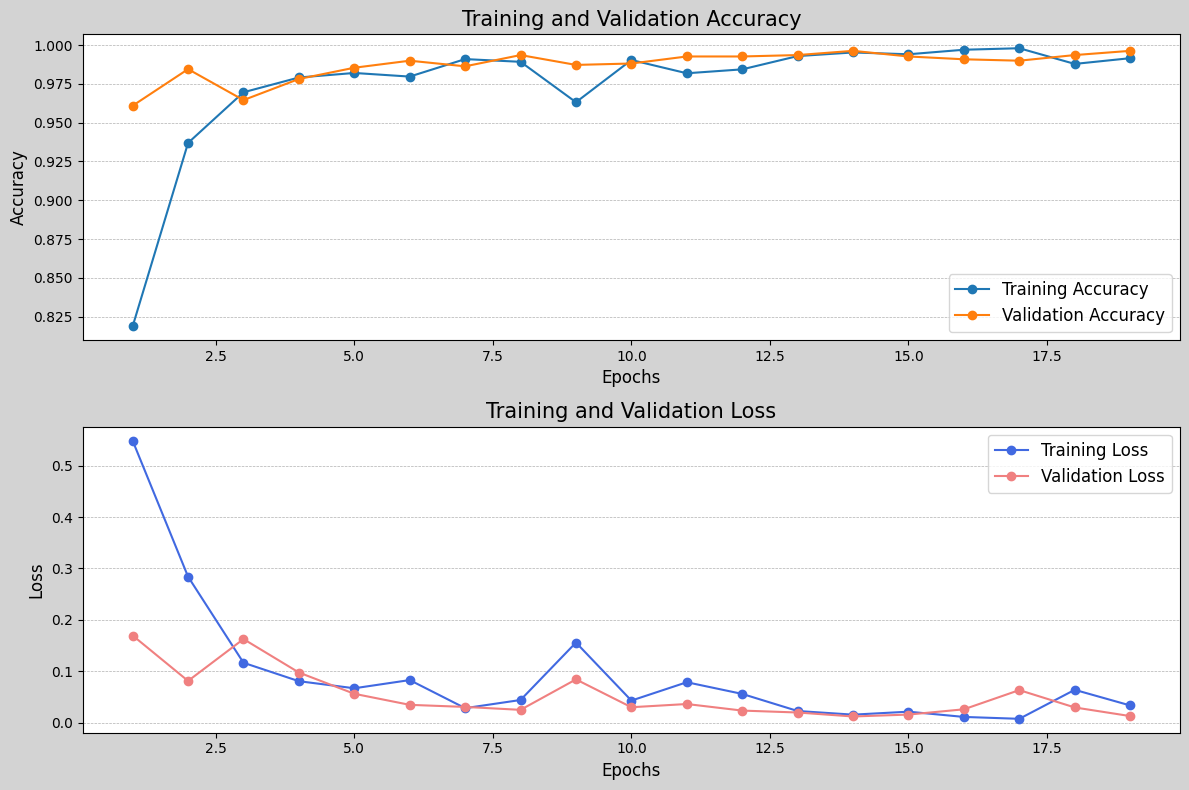

In [20]:
# Let's see the visualization for this first trial
# Starting with Accuracy and Loss
plot_training_history(history1)

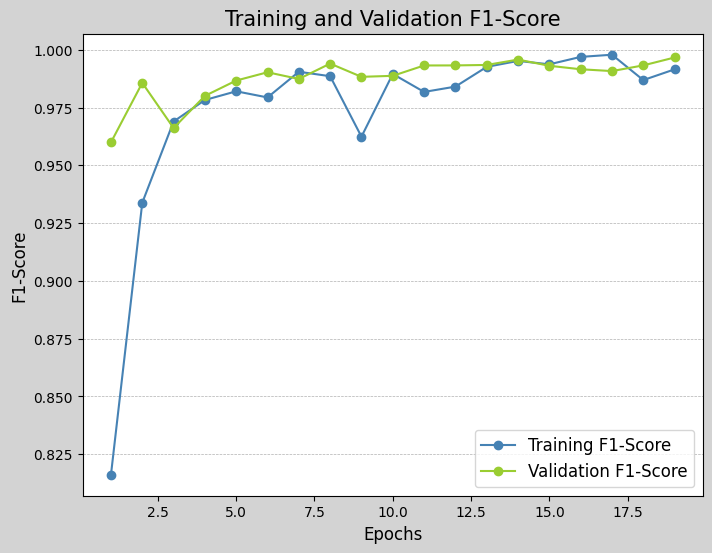

In [21]:
# Let's check out the F1-Score
plot_f1_history(history1)

#

### We have already hit such amazing Accuracy and F1-Score values, that I think we can go ahead and try this model on the test-set.

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test Set F1-Score: 0.9891
Test Set Performance:
              precision    recall  f1-score   support

    Not Spam       0.99      0.99      0.99       551
        Spam       0.99      0.99      0.99       551

    accuracy                           0.99      1102
   macro avg       0.99      0.99      0.99      1102
weighted avg       0.99      0.99      0.99      1102



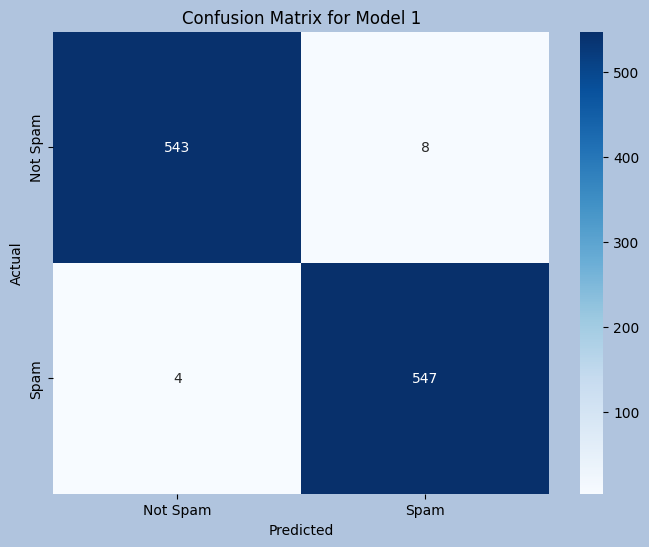

In [22]:
# Generate predictions on the test set
y_test_pred = (model1.predict(X_test) > 0.5).astype("int32")

# Ensure both y_test and y_test_pred are 1D arrays
y_test_np = np.array(y_test).flatten()
y_test_pred_np = np.array(y_test_pred).flatten()

# Calculate F1-score
f1 = f1_score(y_test_np, y_test_pred_np)
print(f"Test Set F1-Score: {f1:.4f}")

# Print classification report
print("Test Set Performance:")
print(classification_report(y_test, y_test_pred, target_names=["Not Spam", "Spam"]))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6), facecolor="lightsteelblue")
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Spam", "Spam"], yticklabels=["Not Spam", "Spam"])
plt.title("Confusion Matrix for Model 1")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


#

### Performance on the test set is equally amazing, so we could simply outright choose this model as our preference, for this part!
### However, for the sake of experimentation, let's try playing around a bit, for example with adding a couple more Dense layers.

#

### **Manual Feedforward Neural Network Experiments (Classifier #1 - Trial #2)**
#### For this trial, I will add two more Dense layers: one with 256 neurons right after the Input layer, and another one with 32 neurons right before the Output layer.
#### These additional layers might increase the capacity of the model to learn complex patterns.
#### Regularization is maintained with the same static Dropout rate of 0.3.

In [23]:
# Define the updated model architecture with additional layers
model2 = Sequential()
model2.add(tf.keras.layers.InputLayer(shape=(X_train.shape[1],)))  # Input layer
model2.add(Dense(256, activation='relu'))  # Added a layer with 256 neurons
model2.add(Dropout(0.3))  # Regularization again, to prevent overfitting
model2.add(Dense(128, activation='relu')) # Previously existing layer
model2.add(Dropout(0.3))
model2.add(Dense(64, activation='relu'))  # previously existing layer
model2.add(Dropout(0.3))
model2.add(Dense(32, activation='relu'))  # New additional layer with 32 neurons
model2.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Custom F1-score metric function again
def f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.round(tf.cast(y_pred, tf.float32))  # Round predictions to 0 or 1
    
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float32'))
    precision = tp / (tf.reduce_sum(tf.cast(y_pred, 'float32')) + tf.keras.backend.epsilon())
    recall = tp / (tf.reduce_sum(tf.cast(y_true, 'float32')) + tf.keras.backend.epsilon())
    return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

# Compiling the model
model2.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', f1_score])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training the updated model
history2 = model2.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stopping],
                    verbose=1)

# Evaluating on the test set
y_pred = (model2.predict(X_test) > 0.5).astype("int32")

# Print classification report
print("Test Set Performance:")
print(classification_report(y_test, y_pred))


Epoch 1/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6427 - f1_score: 0.6494 - loss: 0.8809 - val_accuracy: 0.9065 - val_f1_score: 0.8969 - val_loss: 0.2525
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9032 - f1_score: 0.8981 - loss: 0.3638 - val_accuracy: 0.9555 - val_f1_score: 0.9570 - val_loss: 0.1511
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9428 - f1_score: 0.9406 - loss: 0.2446 - val_accuracy: 0.9546 - val_f1_score: 0.9562 - val_loss: 0.1400
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9745 - f1_score: 0.9738 - loss: 0.0880 - val_accuracy: 0.9764 - val_f1_score: 0.9767 - val_loss: 0.0720
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9819 - f1_score: 0.9818 - loss: 0.0752 - val_accuracy: 0.9791 - val_f1_score: 0.9801 - val_loss: 0.0512
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9749 - f1_score: 0.9740 - loss: 0.0970 - val_accuracy: 0.9918 - val_f1_score: 0.991

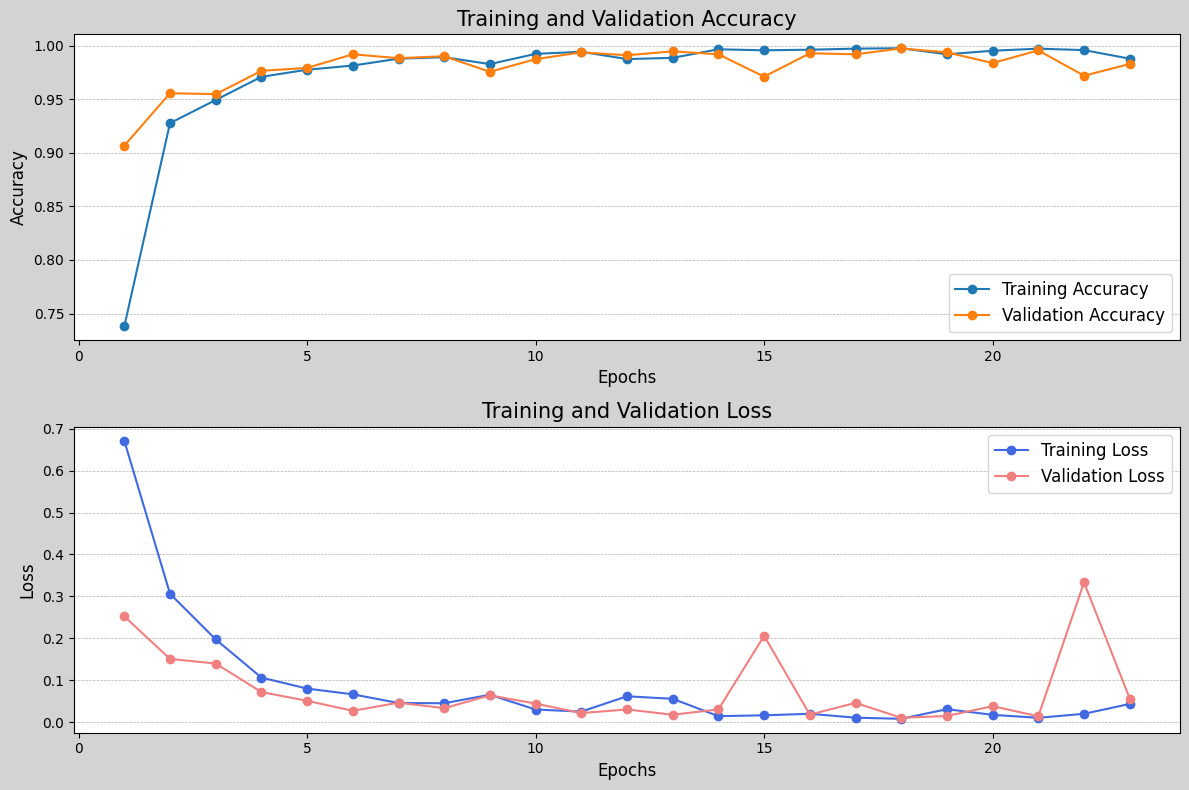

In [24]:
# Let's see the visualization for this second trial
# Starting with Accuracy and Loss
plot_training_history(history2)

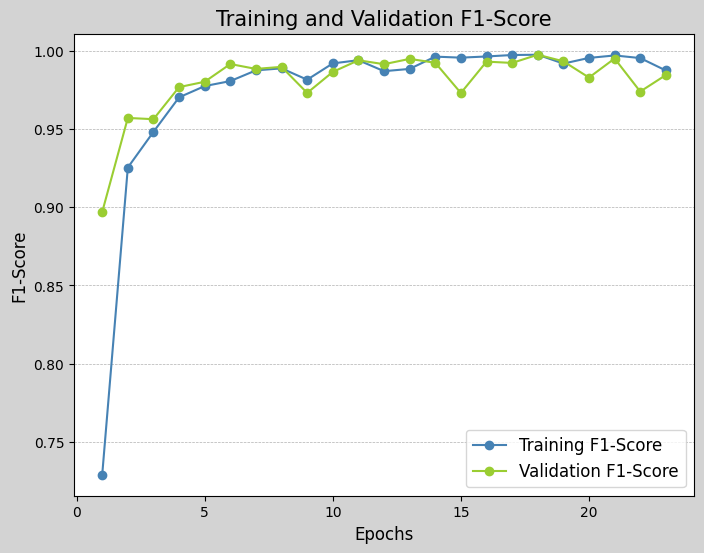

In [25]:
# Let's also check out the F1-Score for this trial
plot_f1_history(history2)

#

### Let's use model2 for predictions on the test-set.

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test Set F1-Score: 0.9928
Test Set Performance:
              precision    recall  f1-score   support

    Not Spam       1.00      0.99      0.99       551
        Spam       0.99      1.00      0.99       551

    accuracy                           0.99      1102
   macro avg       0.99      0.99      0.99      1102
weighted avg       0.99      0.99      0.99      1102



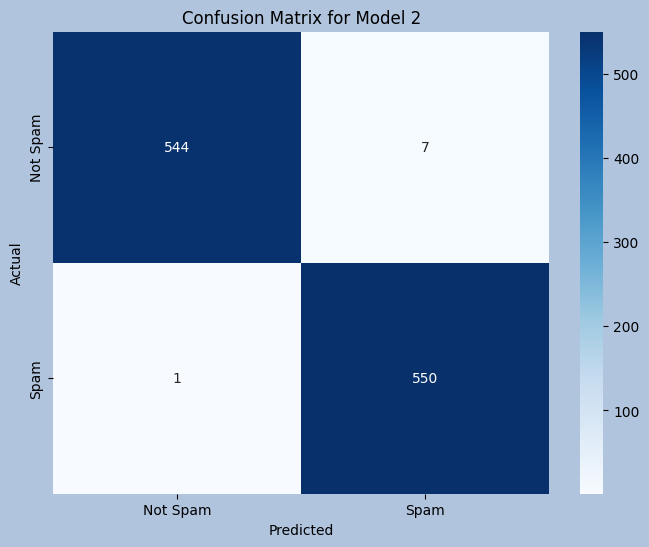

In [26]:
# Generate predictions on the test set
y_test_pred = (model2.predict(X_test) > 0.5).astype("int32")

# Ensure both y_test and y_test_pred are 1D arrays
y_test_np = np.array(y_test).flatten()
y_test_pred_np = np.array(y_test_pred).flatten()

# Calculate F1-score
f1 = f1_score(y_test_np, y_test_pred_np)
print(f"Test Set F1-Score: {f1:.4f}")

# Print classification report
print("Test Set Performance:")
print(classification_report(y_test, y_test_pred, target_names=["Not Spam", "Spam"]))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6), facecolor="lightsteelblue")
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Spam", "Spam"], yticklabels=["Not Spam", "Spam"])
plt.title("Confusion Matrix for Model 2")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


#

### Performance is again quite high, judging both by Accuracy and F1 metrics, and the second model seems to perform better. Although Model 2 performed a little bit worse on the tain/validation data, it seems to generalize better than Model 1 on the test set, achieving an amazing F1-Score of 0.9928.

### In fact, performance on the test set seems to be so exceptionally high, for both models, that there is probably no reason to experiment further with the models hyper-parameters.

### Instead, we can move on to building the second classifier, using a totally different approach, for variety and experimentation purposes!

### (Keeping in mind that the best model for this part, was Model 2)

#

### **Part 3: Transfer Learning - Utilizing a pre-trained model (TabNet) for experimentation (Classifier #2 - Trial #1)**
#### Here we will experiment with the pre-trained TabNet model, to see if a transfer-learning approach yields even better results than the excellent ones we already have.
#### Like I mention in the model compilation description, I will keep the hyper-parameters at more or less standard values, for this trial.
#### I will use Adam optimizer and employ early stopping again, with "patience" parameter set to 10 and max_epochs set to 100.
#### This means that early stopping will occur after 10 epochs of non-improvement, potentially reaching a maximum of 100 epochs total for training.

#### Let's see the results!

In [27]:
# Importing the necessary module
from pytorch_tabnet.tab_model import TabNetClassifier
import torch 

# TabNet expects numpy arrays, so we need to transform the tabular data a little bit
X_train_np = X_train.values
X_val_np = X_val.values
X_test_np = X_test.values
y_train_np = y_train.values
y_val_np = y_val.values
y_test_np = y_test.values

# This is the defiinition of the TabNet model
# For this initial trial I have kept everything to what seem to be default standard values
tabnet_model1 = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, lambda_sparse=1e-3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type="sparsemax"
)

C:\Users\ska_p\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [28]:
# This training might take a little longer than the models of the previous phase
# My GPU doesn't seem to be optimally configured for the TabNet model, so I will train using my CPU

# Train this first model
tabnet_model1.fit(
    X_train=X_train_np, y_train=y_train_np,
    eval_set=[(X_val_np, y_val_np)],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128
)

# Evaluate on the test set
# The model will automatically inform us about when early stopping occurs, and which the best epoch was
y_test_pred = tabnet_model1.predict(X_test_np)
print("Test Set Performance:")
print(classification_report(y_test_np, y_test_pred, target_names=["Not Spam", "Spam"]))


epoch 0  | loss: 1.19349 | val_0_accuracy: 0.49274 |  0:00:16s
epoch 1  | loss: 1.01603 | val_0_accuracy: 0.52178 |  0:00:33s
epoch 2  | loss: 0.94801 | val_0_accuracy: 0.49274 |  0:00:51s
epoch 3  | loss: 0.86491 | val_0_accuracy: 0.61978 |  0:01:08s
epoch 4  | loss: 0.79159 | val_0_accuracy: 0.54628 |  0:01:26s
epoch 5  | loss: 0.81139 | val_0_accuracy: 0.50363 |  0:01:43s
epoch 6  | loss: 0.7907  | val_0_accuracy: 0.57169 |  0:02:00s
epoch 7  | loss: 0.77011 | val_0_accuracy: 0.58348 |  0:02:17s
epoch 8  | loss: 0.70573 | val_0_accuracy: 0.58711 |  0:02:35s
epoch 9  | loss: 0.68538 | val_0_accuracy: 0.62976 |  0:02:52s
epoch 10 | loss: 0.68237 | val_0_accuracy: 0.6343  |  0:03:09s
epoch 11 | loss: 0.6795  | val_0_accuracy: 0.58076 |  0:03:26s
epoch 12 | loss: 0.67015 | val_0_accuracy: 0.58076 |  0:03:43s
epoch 13 | loss: 0.65422 | val_0_accuracy: 0.56715 |  0:03:59s
epoch 14 | loss: 0.63995 | val_0_accuracy: 0.64973 |  0:04:16s
epoch 15 | loss: 0.63025 | val_0_accuracy: 0.60889 |  0

C:\Users\ska_p\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Test Set Performance:
              precision    recall  f1-score   support

    Not Spam       0.97      0.94      0.96       551
        Spam       0.94      0.97      0.96       551

    accuracy                           0.96      1102
   macro avg       0.96      0.96      0.96      1102
weighted avg       0.96      0.96      0.96      1102



Test Set F1-Score: 0.9572
Test Set Performance:
              precision    recall  f1-score   support

    Not Spam       0.97      0.94      0.96       551
        Spam       0.94      0.97      0.96       551

    accuracy                           0.96      1102
   macro avg       0.96      0.96      0.96      1102
weighted avg       0.96      0.96      0.96      1102



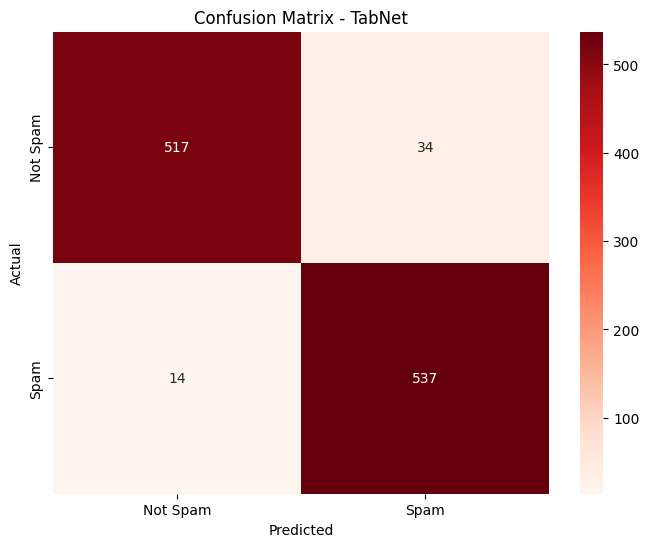

In [30]:
# The TabNet model doesn't seem to perform as well as the models trained in the first phase, but still the performance is quite good
# Let's generate some predictions on the test set
y_test_pred = tabnet_model1.predict(X_test_np)

# Calculate F1-score
f1 = f1_score(y_test_np, y_test_pred)
print(f"Test Set F1-Score: {f1:.4f}")

# Full classification report
print("Test Set Performance:")
print(classification_report(y_test_np, y_test_pred, target_names=["Not Spam", "Spam"]))


# Confusion Matrix
conf_matrix = confusion_matrix(y_test_np, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=["Not Spam", "Spam"], yticklabels=["Not Spam", "Spam"])
plt.title("Confusion Matrix - TabNet")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


#

### It seems that TabNet's performance on the test-set is considerably lower than that of the models in the previous phase.
### I will conclude that the preferred model for this exercise is Model2, from the second trial of Classifier #1.

### Here is model2 used for predictions on the test set, once again, to finish this notebook:

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test Set F1-Score: 0.9928
Test Set Performance:
              precision    recall  f1-score   support

    Not Spam       1.00      0.99      0.99       551
        Spam       0.99      1.00      0.99       551

    accuracy                           0.99      1102
   macro avg       0.99      0.99      0.99      1102
weighted avg       0.99      0.99      0.99      1102



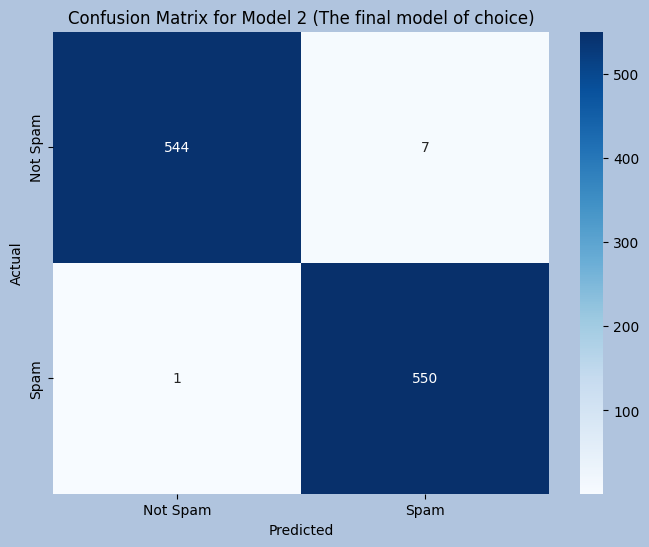

In [33]:
# Generate predictions on the test set with the best model, once again
y_test_pred = (model2.predict(X_test) > 0.5).astype("int32")

# Ensure both y_test and y_test_pred are 1D arrays
y_test_np = np.array(y_test).flatten()
y_test_pred_np = np.array(y_test_pred).flatten()

# Calculate F1-score
f1 = f1_score(y_test_np, y_test_pred_np)
print(f"Test Set F1-Score: {f1:.4f}")

# Print classification report
print("Test Set Performance:")
print(classification_report(y_test, y_test_pred, target_names=["Not Spam", "Spam"]))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6), facecolor="lightsteelblue")
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Spam", "Spam"], yticklabels=["Not Spam", "Spam"])
plt.title("Confusion Matrix for Model 2 (The final model of choice)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
